In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchattacks
import foolbox as fb
from torchvision.models import resnet50
import warnings
warnings.filterwarnings("ignore")

In [2]:
"""preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])"""
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a specific size
    transforms.ToTensor(),         # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize pixel values
])
# number of each classes
num_nor = 133
num_mal = 210
num_ben = 437

classes = {0:'normal', 1:'malignant', 2:'benign'}

X = []
y = []
for i in range(1,num_nor+1):
    p = f"normal/normal ({i}).png"
    X.append(preprocess(Image.open(p))[None,:,:,:][0])
    y.append(torch.tensor(0))
    
for i in range(1,num_mal+1):
    p = f"malignant/malignant ({i}).png"
    X.append(preprocess(Image.open(p))[None,:,:,:][0])
    y.append(torch.tensor(1))
    
for i in range(1,num_ben+1):
    p = f"benign/benign ({i}).png"
    X.append(preprocess(Image.open(p))[None,:,:,:][0])
    y.append(torch.tensor(2))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [4]:
np.shape(X_train)

(624,)

In [5]:
batch = 32
# Define a custom dataset class
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create an instance of the dataset
train_loader = DataLoader(CustomDataset(X_train, y_train),batch_size=batch, shuffle=True)
test_loader = DataLoader(CustomDataset(X_test, y_test), batch_size=batch, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


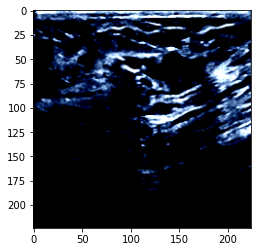

In [6]:
plt.imshow(X_train[0].numpy().transpose(1,2,0))

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Adjust the input size according to your image size
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x
   

#Create an instance of the model with 3 output classes
#num_classes = 3
#model = SimpleCNN(num_classes)

In [8]:
def fit_without_attack(model,num_classes,num_epochs):# Define a loss function and an optimizer
    model = model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of training epochs
    # num_epochs = 10
    # 
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # Disable gradient computation for evaluation
        #with torch.no_grad():
        for inputs, labels in test_loader:

            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')

    print('Training finished')
    return model

In [9]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image adding clipping to maintain [-1,1] range
    return torch.clamp(perturbed_image, -1, 1)
# Create a DataLoader from the shuffled training data

def Advesarial_attack(model, test_loader, epsilon):
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=1e-4)
    total = 0
    check = 0
    # loop through the test set
    perturbed_image = []
    perturbed_image_label = []
    for x,y in test_loader:
        x.requires_grad = True
        output = model(x)
        predict = output.argmax(dim=1)
        if torch.all(predict == y):
            continue
        optimizer.zero_grad()
        loss = objective(output,y)
        loss.backward(retain_graph=True)
        data_grad = x.grad.data
        perturbed_data = fgsm_attack(x, epsilon, data_grad)
        for i in range(len(perturbed_data)):
            perturbed_image.append(perturbed_data[i])
            perturbed_image_label.append(y[i])
        output = model(perturbed_data).argmax().cpu()
        
        check += (predict == y).sum().item()
        total += len(y)
    return check/total, perturbed_image, np.array(perturbed_image_label).flatten()

In [10]:
num_class = 3
model1 = fit_without_attack(SimpleCNN,3,10)

Epoch [1/10] - Loss(train): 0.1471 - Accuracy(test): 0.5064102564102564
Epoch [2/10] - Loss(train): 0.1191 - Accuracy(test): 0.6025641025641025
Epoch [3/10] - Loss(train): 0.1102 - Accuracy(test): 0.6025641025641025
Epoch [4/10] - Loss(train): 0.0990 - Accuracy(test): 0.6346153846153846
Epoch [5/10] - Loss(train): 0.0830 - Accuracy(test): 0.6666666666666666
Epoch [6/10] - Loss(train): 0.0597 - Accuracy(test): 0.6987179487179487
Epoch [7/10] - Loss(train): 0.0380 - Accuracy(test): 0.7435897435897436
Epoch [8/10] - Loss(train): 0.0226 - Accuracy(test): 0.7564102564102564
Epoch [9/10] - Loss(train): 0.0110 - Accuracy(test): 0.7435897435897436
Epoch [10/10] - Loss(train): 0.0083 - Accuracy(test): 0.7243589743589743
Training finished


In [49]:
## loop through 5 times to get error bar
eps = 0.5

In [50]:
acc, perturbed_image,perturbed_image_label = Advesarial_attack(model1, test_loader, eps)
adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


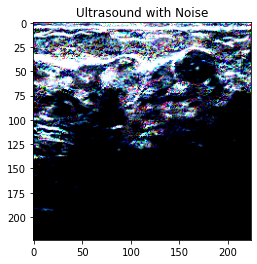

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 2
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


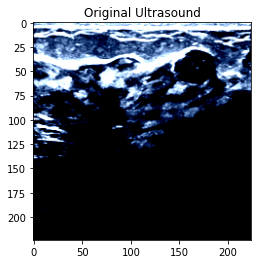

Label: 2


In [51]:
adv_test_features, adv_test_labels = next(iter(adv_test_loader))
print(f"Feature batch shape: {adv_test_features.size()}")
print(f"Labels batch shape: {adv_test_labels.size()}")
img = adv_test_features[0].squeeze()
label = adv_test_labels[0]
plt.title('Ultrasound with Noise')
plt.imshow(img.detach().numpy().transpose(1,2,0), cmap="gray")
plt.savefig('nosie')
plt.show()
print(f"Label: {label}")

test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.title('Original Ultrasound')
plt.imshow(img.detach().numpy().transpose(1,2,0), cmap="gray")
plt.savefig('original')
plt.show()

print(f"Label: {label}")


In [52]:
total_stats_o = []
total_attack_stats_o = []
for _ in range(5):
    model = SimpleCNN(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of training epochs
    num_epochs = 10
    stats = []
    attack_stats = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        correct_adv = 0
        total = 0

        # Disable gradient computation for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            for inputs, labels in adv_test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                correct_adv += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total
        adv_accuracy = correct_adv / total
        stats.append([average_loss, accuracy])
        #print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')
        #acc, perturbed_image,perturbed_image_label = Advesarial_attack(model, test_loader, 0.3)
        #adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)
        attack_stats.append(adv_accuracy)
        
    total_stats_o.append(stats)
    total_attack_stats_o.append(attack_stats)
    print('Training finished')

Training finished
Training finished
Training finished
Training finished
Training finished


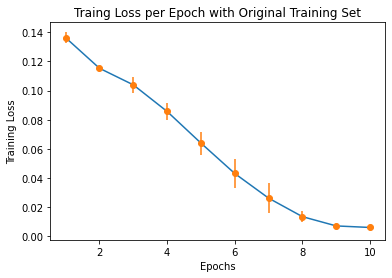

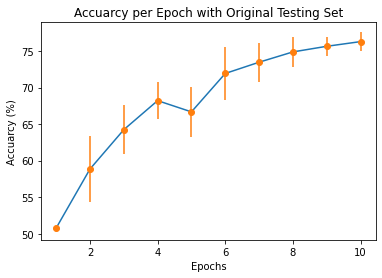

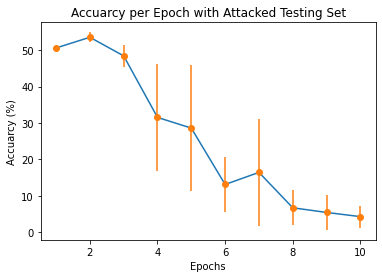

In [53]:
all_loss_no_adv = np.array(total_stats_o).T[0]
all_acc_no_adv = np.array(total_stats_o).T[1]
x = np.linspace(1,10,10)
avg_loss_no_adv = []
err_loss_no_adv = []
for i in range(len(all_loss_no_adv)):
    avg_loss_no_adv.append(np.mean(all_loss_no_adv[i]))
    err_loss_no_adv.append(np.std(all_loss_no_adv[i]))

plt.plot(x,avg_loss_no_adv)
plt.errorbar(x, avg_loss_no_adv, yerr = err_loss_no_adv,fmt ='o')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Traing Loss per Epoch with Original Training Set')
plt.savefig("loss_original3")
plt.show()
avg_acc_no_adv = []
err_acc_no_adv = []
for i in range(len(all_loss_no_adv)):
    avg_acc_no_adv.append(np.mean(all_acc_no_adv[i])*100)
    err_acc_no_adv.append(np.std(all_acc_no_adv[i])*100)

plt.plot(x,avg_acc_no_adv)
plt.errorbar(x, avg_acc_no_adv, yerr = err_acc_no_adv,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Original Testing Set')
plt.savefig('acc_original3')
plt.show()
x = np.linspace(1,10,10)
all_attack_stats_no_adv = np.array(total_attack_stats_o).T
avg_attack_no_adv = []
err_attack_no_adv = []
for i in range(len(all_attack_stats_no_adv)):
    avg_attack_no_adv.append(np.mean(all_attack_stats_no_adv[i]*100))
    err_attack_no_adv.append(np.std(all_attack_stats_no_adv[i]*100))

plt.plot(x,avg_attack_no_adv)
plt.errorbar(x, avg_attack_no_adv, yerr = err_attack_no_adv,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Testing Set')
plt.savefig('acc_attack3')
plt.show()

In [54]:
def fit_with_attack(model,num_classes,num_epochs):# Define a loss function and an optimizer
    model = model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of training epochs
    # num_epochs = 10
    # 
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in adv_train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward(retain_graph=True)

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        total = 0

        # Disable gradient computation for evaluation
        #with torch.no_grad():
        for inputs, labels in test_loader:

            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total

        print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')

    print('Training finished')
    return model

In [55]:
acc, perturbed_image,perturbed_image_label = Advesarial_attack(model1, train_loader, eps)
adv_train_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=True)

In [56]:
total_stats_train_adv_o = []
total_attack_stats_train_adv_o = []
for _ in range(5):
    model = SimpleCNN(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of training epochs
    num_epochs = 10
    stats = []
    attack_stats = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in adv_train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward(retain_graph=True)

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        correct_adv = 0
        total = 0

        # Disable gradient computation for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            for inputs, labels in adv_test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                correct_adv += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total
        adv_accuracy = correct_adv / total
        stats.append([average_loss, accuracy])
        #print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')
        #acc, perturbed_image,perturbed_image_label = Advesarial_attack(model, test_loader, 0.3)
        #adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)
        attack_stats.append(adv_accuracy)
    total_stats_train_adv_o.append(stats)
    total_attack_stats_train_adv_o.append(attack_stats)
    print('Training finished')

Training finished
Training finished
Training finished
Training finished
Training finished


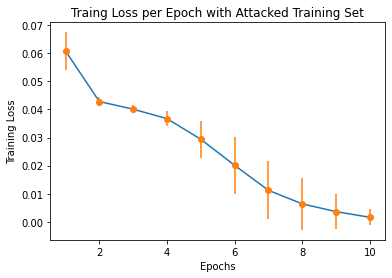

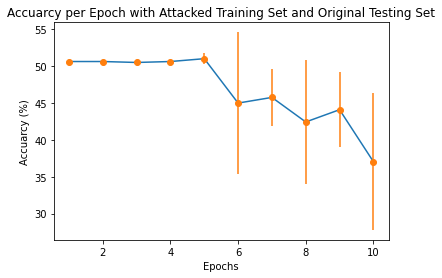

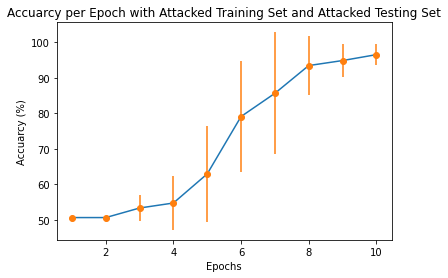

In [57]:
all_loss = np.array(total_stats_train_adv_o).T[0]
all_acc = np.array(total_stats_train_adv_o).T[1]
x = np.linspace(1,10,10)
avg_loss = []
err_loss = []
for i in range(len(all_loss)):
    avg_loss.append(np.mean(all_loss[i]))
    err_loss.append(np.std(all_loss[i]))

plt.plot(x,avg_loss)
plt.errorbar(x, avg_loss, yerr = err_loss,fmt ='o')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Traing Loss per Epoch with Attacked Training Set')
plt.savefig("loss_train_attacked")
plt.show()

avg_acc = []
err_acc = []
for i in range(len(all_loss)):
    avg_acc.append(np.mean(all_acc[i])*100)
    err_acc.append(np.std(all_acc[i])*100)

plt.plot(x,avg_acc)
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set and Original Testing Set')
plt.savefig('acc_train_attacked_test_original')
plt.show()
#x = np.linspace(1,10,10)
all_attack_stats = np.array(total_attack_stats_train_adv_o).T
avg_attack = []
err_attack = []
for i in range(len(all_attack_stats)):
    avg_attack.append(np.mean(all_attack_stats[i]*100))
    err_attack.append(np.std(all_attack_stats[i]*100))

plt.plot(x,avg_attack)
plt.errorbar(x, avg_attack, yerr = err_attack,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set and Attacked Testing Set')
plt.savefig('acc_train_attacked_test_attacked')
plt.show()

10


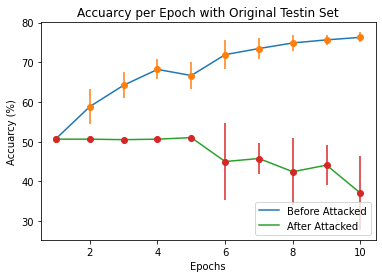

In [58]:
plt.plot(x,avg_acc_no_adv, label = "Before Attacked")
plt.errorbar(x, avg_acc_no_adv, yerr = err_acc_no_adv,fmt ='o')

print(len(avg_acc))

plt.plot(x,avg_acc,label = "After Attacked")
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Original Testin Set')
plt.legend(loc='lower right')
plt.savefig('acc_no_vs_attacked_on_o')
plt.show()

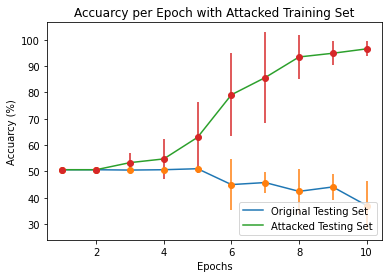

In [59]:
plt.plot(x,avg_acc, label = "Original Testing Set")
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')

#x = np.linspace(1,10,10)
all_attack_stats = np.array(total_attack_stats_train_adv_o).T
avg_attack = []
err_attack = []
for i in range(len(all_attack_stats)):
    avg_attack.append(np.mean(all_attack_stats[i]*100))
    err_attack.append(np.std(all_attack_stats[i]*100))

plt.plot(x,avg_attack,label = "Attacked Testing Set")
plt.errorbar(x, avg_attack, yerr = err_attack,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set')
plt.legend(loc='lower right')
plt.savefig('acc_train_attacked_o_both')
plt.show()

In [552]:
def buildResNet50Model(numClasses):
    # get the stock PyTorch ResNet50 model w/ pretrained set to True
    model = torchvision.models.resnet50(pretrained = True)

    # freeze all model parameters so we don’t backprop through them during training (except the FC layer that will be replaced)
    for param in model.parameters():
        param.requires_grad = False
    # end for
    
    # !!!!!! this line is specific to the 3 channel to one channel change, other lines in this function are the same as before !!!!!!
    # change 1st conv layer from 3 channel to 1 channel
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # the last (fully connected) layer per the number of classes
    # first, get/save the current number of input features to the fc layer
    numFcInputs = model.fc.in_features
    # now replace the fc layer with minor changes, and using our number of classes
    model.fc = nn.Sequential(nn.Linear(numFcInputs, 256),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(256, numClasses))

    return model
# end function

In [557]:
model2 = fit_without_attack(buildResNet50Model,3,10)

Epoch [1/10] - Loss(train): 0.1393 - Accuracy(test): 0.38461538461538464
Epoch [2/10] - Loss(train): 0.1209 - Accuracy(test): 0.5833333333333334
Epoch [3/10] - Loss(train): 0.1155 - Accuracy(test): 0.5897435897435898
Epoch [4/10] - Loss(train): 0.1075 - Accuracy(test): 0.5897435897435898
Epoch [5/10] - Loss(train): 0.1001 - Accuracy(test): 0.6794871794871795
Epoch [6/10] - Loss(train): 0.0974 - Accuracy(test): 0.6153846153846154
Epoch [7/10] - Loss(train): 0.0877 - Accuracy(test): 0.717948717948718
Epoch [8/10] - Loss(train): 0.0795 - Accuracy(test): 0.7051282051282052
Epoch [9/10] - Loss(train): 0.0795 - Accuracy(test): 0.5897435897435898
Epoch [10/10] - Loss(train): 0.0838 - Accuracy(test): 0.6858974358974359
Training finished


In [559]:
acc, perturbed_image,perturbed_image_label = Advesarial_attack(model2, test_loader, 0.5)
adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)

In [560]:
total_stats = []
total_attack_stats = []
num_epochs = 10
for _ in range(5):
    model = buildResNet50Model(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Number of training epochs
    stats = []
    attack_stats = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        correct_adv = 0
        total = 0

        # Disable gradient computation for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            for inputs, labels in adv_test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                correct_adv += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total
        adv_accuracy = correct_adv / total
        stats.append([average_loss, accuracy])
        #print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')
        #acc, perturbed_image,perturbed_image_label = Advesarial_attack(model, test_loader, 0.3)
        #adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)
        attack_stats.append(adv_accuracy)
        
    total_stats.append(stats)
    total_attack_stats.append(attack_stats)
    print('Training finished')

Training finished
Training finished
Training finished
Training finished
Training finished


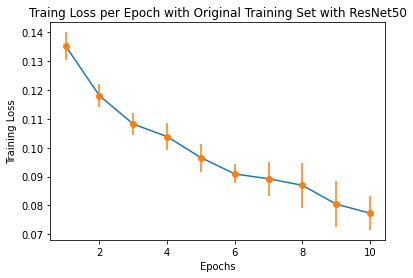

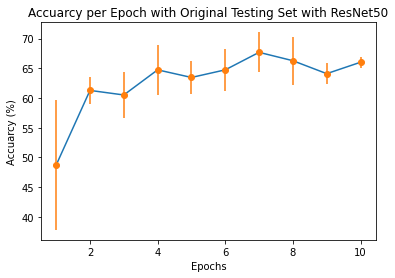

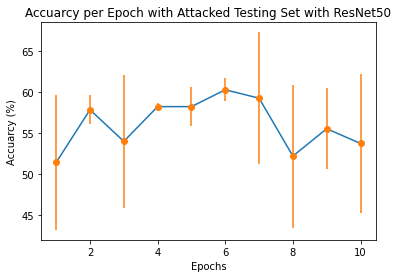

In [562]:
all_loss = np.array(total_stats).T[0]
all_acc = np.array(total_stats).T[1]
x = np.linspace(1,10,10)
avg_loss = []
err_loss = []
for i in range(len(all_loss)):
    avg_loss.append(np.mean(all_loss[i]))
    err_loss.append(np.std(all_loss[i]))

plt.plot(x,avg_loss)
plt.errorbar(x, avg_loss, yerr = err_loss,fmt ='o')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Traing Loss per Epoch with Original Training Set (ResNet50)')
plt.savefig("loss_original_resnet")
plt.show()
avg_acc = []
err_acc = []
for i in range(len(all_loss)):
    avg_acc.append(np.mean(all_acc[i])*100)
    err_acc.append(np.std(all_acc[i])*100)

plt.plot(x,avg_acc)
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Original Testing Set (ResNet50)')
plt.savefig('acc_original_resnet')
plt.show()
x = np.linspace(1,10,10)
all_attack_stats = np.array(total_attack_stats).T
avg_attack = []
err_attack = []
for i in range(len(all_attack_stats)):
    avg_attack.append(np.mean(all_attack_stats[i]*100))
    err_attack.append(np.std(all_attack_stats[i]*100))

plt.plot(x,avg_attack)
plt.errorbar(x, avg_attack, yerr = err_attack,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Testing Set (ResNet50)')
plt.savefig('acc_attack_resnet')
plt.show()

In [563]:
acc, perturbed_image,perturbed_image_label = Advesarial_attack(model2, train_loader, 0.3)
adv_train_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=True)

In [566]:
total_stats_train_adv = []
total_attack_stats_train_adv = []
for _ in range(5):
    model = buildResNet50Model(3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Number of training epochs
    num_epochs = 10
    stats = []
    attack_stats = []
    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        loss_total = 0
        for inputs, labels in adv_train_loader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward(retain_graph=True)

            loss_total += loss.item()
            optimizer.step()

        # Evaluate the model using the test_loader
        model.eval()  # Set the model to evaluation mode

        correct = 0
        correct_adv = 0
        total = 0

        # Disable gradient computation for evaluation
        with torch.no_grad():
            for inputs, labels in test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            for inputs, labels in adv_test_loader:

                outputs = model(inputs)

                _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability

                correct_adv += (predicted == labels).sum().item()

        average_loss = loss_total / total
        accuracy = correct / total
        adv_accuracy = correct_adv / total
        stats.append([average_loss, accuracy])
        #print(f'Epoch [{epoch+1}/{num_epochs}] - Loss(train): {average_loss:.4f} - Accuracy(test): {accuracy}')
        #acc, perturbed_image,perturbed_image_label = Advesarial_attack(model, test_loader, 0.3)
        #adv_test_loader = DataLoader(CustomDataset(perturbed_image, perturbed_image_label), batch_size=32, shuffle=False)
        attack_stats.append(adv_accuracy)
    total_stats_train_adv.append(stats)
    total_attack_stats_train_adv.append(attack_stats)
    print('Training finished')

Training finished
Training finished
Training finished
Training finished
Training finished


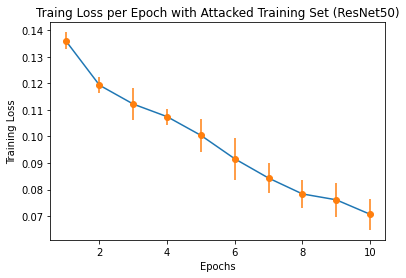

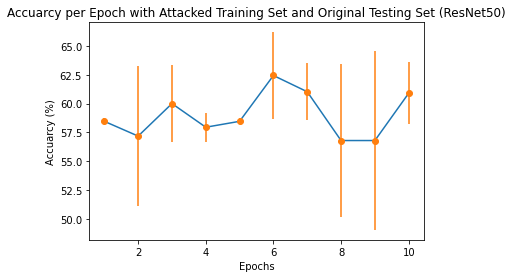

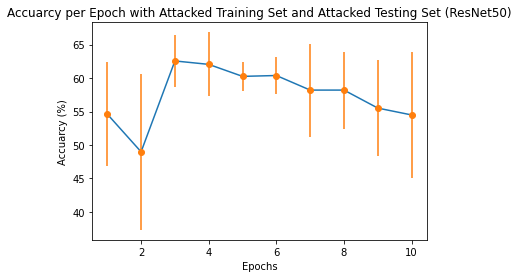

In [567]:
all_loss = np.array(total_stats_train_adv).T[0]
all_acc = np.array(total_stats_train_adv).T[1]
x = np.linspace(1,10,10)
avg_loss = []
err_loss = []
for i in range(len(all_loss)):
    avg_loss.append(np.mean(all_loss[i]))
    err_loss.append(np.std(all_loss[i]))

plt.plot(x,avg_loss)
plt.errorbar(x, avg_loss, yerr = err_loss,fmt ='o')
plt.ylabel('Training Loss')
plt.xlabel('Epochs')
plt.title('Traing Loss per Epoch with Attacked Training Set (ResNet50)')
plt.savefig("loss_train_attacked_res")
plt.show()

avg_acc = []
err_acc = []
for i in range(len(all_loss)):
    avg_acc.append(np.mean(all_acc[i])*100)
    err_acc.append(np.std(all_acc[i])*100)

plt.plot(x,avg_acc)
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set and Original Testing Set (ResNet50)')
plt.savefig('acc_train_attacked_test_original_res')
plt.show()
#x = np.linspace(1,10,10)
all_attack_stats = np.array(total_attack_stats_train_adv).T
avg_attack = []
err_attack = []
for i in range(len(all_attack_stats)):
    avg_attack.append(np.mean(all_attack_stats[i]*100))
    err_attack.append(np.std(all_attack_stats[i]*100))

plt.plot(x,avg_attack)
plt.errorbar(x, avg_attack, yerr = err_attack,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set and Attacked Testing Set (ResNet50)')
plt.savefig('acc_train_attacked_test_attacked_res')
plt.show()

NameError: name 'total_attack_stats_train_adv' is not defined

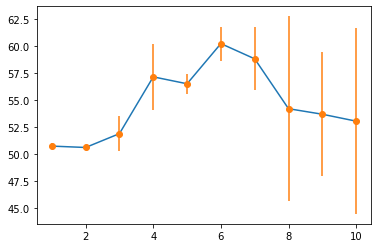

In [37]:
plt.plot(x,avg_acc, label = "Original Testing Set")
plt.errorbar(x, avg_acc, yerr = err_acc,fmt ='o')

#x = np.linspace(1,10,10)
all_attack_stats = np.array(total_attack_stats_train_adv).T
avg_attack = []
err_attack = []
for i in range(len(all_attack_stats)):
    avg_attack.append(np.mean(all_attack_stats[i]*100))
    err_attack.append(np.std(all_attack_stats[i]*100))

plt.plot(x,avg_attack,label = "Attacked Testing Set")
plt.errorbar(x, avg_attack, yerr = err_attack,fmt ='o')
plt.ylabel('Accuarcy (%)')
plt.xlabel('Epochs')
plt.title('Accuarcy per Epoch with Attacked Training Set (ResNet50)')
plt.legend(loc='lower right')
#plt.savefig('acc_train_attacked_res_both')
plt.show()